<a href="https://colab.research.google.com/github/sumanyurosha/hackathons/blob/master/AnalyticsVidya/JanataHackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement
We are given a dataset of vehicles where we have to classify them as **Emergency** (like Ambulance, Fire-brigade, Police car) and **Non-emergency** (like car, bus, truck) vehicles. 

# Solution Proposed
I will use a pre-trained model like VGG or Resnet as a feature extractor and then re-train the classifier layer of it for the above task.

# Steps for Vehicle Classification

1.   Downloading/unzip the dataset 
2.   Making a custom Data Loader
3.   Visualizing the Dataset
4.   Designing the model architecture
5.   Traing the model
6.   Model evaluation







In [ ]:
import pandas as pd
import torch
import os
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from skimage import io

class VehicleDataset(Dataset):

    def __init__(self, csv_file, image_dir, transform, train=True):

        self.vehicle_mapping = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.vehicle_mapping)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_path = os.path.join(self.image_dir, self.vehicle_mapping.iloc[idx, 0])
        image = io.imread(image_path)
        image = self.transform(image)
        if (self.train):
            label = torch.tensor(int(self.vehicle_mapping.iloc[idx, 1]))
            return (image, label)
        else:
            return image

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

# number of samples per batch
batch_size = 20
# validation set size
valid_size = 0.2
# test set size
test_size = 0.2

image_dir = "/content/drive/My Drive/Resources/Dataset/janata-hackathon/images"
train_csv_file = "/content/drive/My Drive/Resources/Dataset/janata-hackathon/train.csv"
test_csv_file = "/content/drive/My Drive/Resources/Dataset/janata-hackathon/test_vc2kHdQ.csv"

train_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5),
                                                          (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5),
                                                          (0.5, 0.5, 0.5))])

train_dataset = VehicleDataset(train_csv_file, image_dir, train_transform, 
                               train=True)
test_dataset = VehicleDataset(test_csv_file, image_dir, test_transform, 
                              train=False)

# obtain training indices that will be used for validation
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
    sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

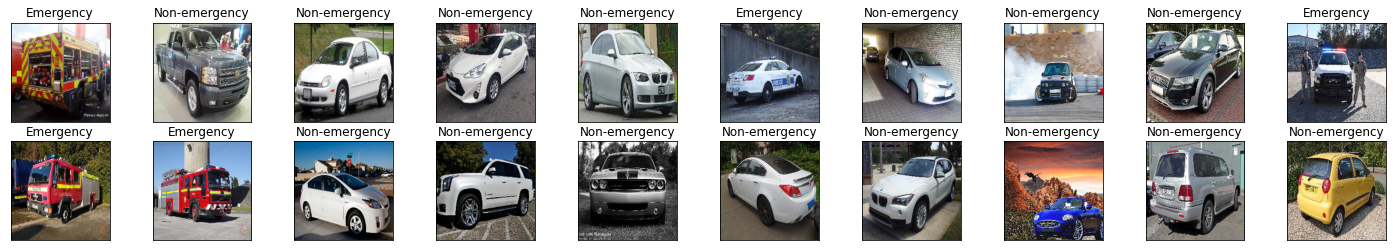

In [ ]:
classes = ['Non-emergency', 'Emergency']

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [ ]:
# downloading the pretrained model
model = models.vgg16(pretrained=True)

model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print("GPU is available!")
else:
    print("GPU is not available!")

GPU is available!


In [ ]:
# freezing the feature extracting layer
for param in model.features.parameters():
    param.requires_grad = False

# modifying the existing last layer of classifier for our use case
model.classifier[6].out_features = len(classes)

# reviewing the changes
print(model.classifier)

if train_on_gpu:
    model = model.cuda()

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)


In [ ]:
from torch import optim, nn

# specify the loss
criterion = nn.CrossEntropyLoss()

# specify the optimizer
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001)

In [ ]:
epochs = 10

valid_loss_min = np.Inf

for epoch in range(epochs):
    
    train_loss = 0.
    valid_loss = 0.

    # training the model
    model.train()
    for images, labels in train_loader:
        # sending the tensors to cuda if gpu is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()

        # clearing the accumulated gradients
        optimizer.zero_grad()
        # forward pass
        output = model(images)
        # calculating the batch loss
        loss = criterion(output, labels)
        # back propagation
        loss.backward()
        # updating the weights
        optimizer.step()

        # updatind the training loss
        train_loss += loss.item()*images.size(0)
    
    # evaluating the model
    model.eval()
    for images, labels in valid_loader:
        # sending the tensors to CUDA if GPU is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()

        # predicting the outcomes
        output = model(images)
        # calculating the loss
        loss = criterion(output, labels)

        # updating the validation loss
        valid_loss += loss.item()*images.size(0)

    # calculating the average losses
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)

    # printing the loss for each epoch
    print("Epoch {}: , training loss: {:.6f}, validation loss: {:.6f}".format(epoch+1, 
                                                                      train_loss,
                                                                      valid_loss))
    
    if valid_loss < valid_loss_min:
        print("Validation loss decreased from {:.6f} --> {:.6f}. Saving the model...".
              format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss


Epoch 1: , training loss: 2.802326, validation loss: 0.076017
Validation loss decreased from inf --> 0.076017. Saving the model...
Epoch 2: , training loss: 0.333586, validation loss: 0.056943
Validation loss decreased from 0.076017 --> 0.056943. Saving the model...
Epoch 3: , training loss: 0.265851, validation loss: 0.048320
Validation loss decreased from 0.056943 --> 0.048320. Saving the model...
Epoch 4: , training loss: 0.211211, validation loss: 0.045420
Validation loss decreased from 0.048320 --> 0.045420. Saving the model...
Epoch 5: , training loss: 0.197997, validation loss: 0.041628
Validation loss decreased from 0.045420 --> 0.041628. Saving the model...
Epoch 6: , training loss: 0.162826, validation loss: 0.039107
Validation loss decreased from 0.041628 --> 0.039107. Saving the model...
Epoch 7: , training loss: 0.143942, validation loss: 0.037911
Validation loss decreased from 0.039107 --> 0.037911. Saving the model...
Epoch 8: , training loss: 0.138689, validation loss: 

In [ ]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [ ]:
model.eval()
#test_set = next(iter(test_loader))
test_results = []
for images in test_loader:
    # if GPU is available, sending the data to it
    if train_on_gpu:
        images = images.cuda()
    # taking out the predictions
    output = model(images)
    # coverting model probabilities to predicted classes
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
    test_results.extend(preds)

In [ ]:
print(len(test_results))
print(test_results)

706
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,

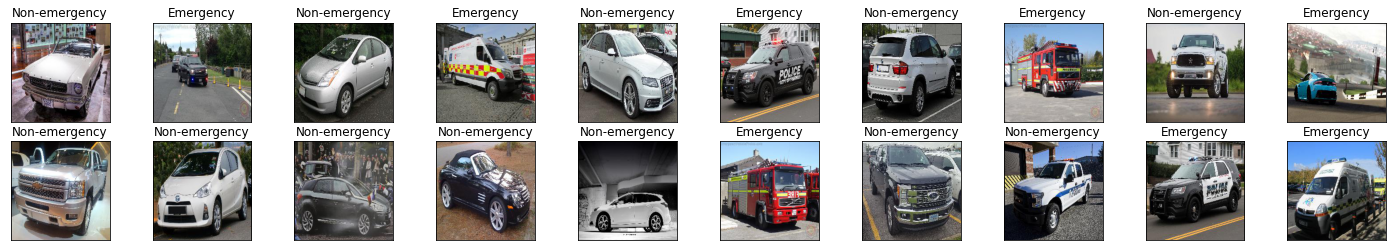

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))

#saving images to CPU to avoid errors
images = images.cpu()

for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{}".format(classes[preds[idx]]))

In [ ]:
df = pd.read_csv(test_csv_file)
df["emergency_or_not"] = test_results
df.to_csv("submission.csv", index=False)